In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from transformers import BertModel
from transformers import BertTokenizer
from sklearn.metrics import roc_auc_score
import pickle
import networkx as nx
from collections import deque
import time

In [2]:
def draw_tree(nodes, edges):
    tree = nx.DiGraph()
    tree.add_nodes_from(nodes)
    tree.add_edges_from(edges)
    nx.draw_networkx(tree)

def merge_tree(node, node_tree, parent_children):
    tree = node_tree[node]
    queue = parent_children[node]
    while queue:
        child = queue.pop()
        node_tree[child] = tree
        if child in parent_children:
            for c in parent_children[child]:
                queue.add(c)

def build_tree(seq, data):
    node_tid = dict()
    tid_node = dict()
    tid_data = dict()
    parent_children = dict()
    child_parent = dict()
    node_tree = {0:0}
    cur_tree_id = 1
    
    nodes = []
    edges = []
    
    ids = seq.strip().split(',')
    for i in range(len(ids)):
        ids[i] = int(ids[i].strip())
    
    filtered_ids = []
    for id_ in ids:
        if len(data[data.tweet_id == id_]) > 0:
            filtered_ids.append(id_)
    ids = filtered_ids
    # print(len(ids))
    if len(ids) == 0:
        return None
    # print(ids)
    for i, id_ in enumerate(ids):
        node_tid[i] = id_
        tid_node[id_] = i
        tid_data[id_] = data[data.tweet_id == id_].drop(columns=['tweet_id'])
        # print(data[data.tweet_id == id_].drop(columns=['tweet_id']))
    
    # for i in range(len(ids)):
    #     node_tree[i] = i
    # print(node_tid)
    # print(tid_node)
    for i, id_ in enumerate(ids):
        p_tid = tid_data[id_].in_reply_to_status_id.iloc[0]
        try:
            p_tid = int(p_tid)
        except:
            p_tid = None

        if p_tid is not None:
            if p_tid not in ids:
                p_tid = list(tid_node.keys())[0]
            p_node = tid_node[p_tid]
            if i == 0:
                continue
            else:
                child_parent[i] = p_node
                if p_node not in parent_children:
                    parent_children[p_node] = set()
                parent_children[p_node].add(i)

                if p_node in node_tree:
                    merge_tree(p_node, node_tree, parent_children)
                else: # create new tree
                    cur_tree_id = len(node_tree)
                    node_tree[i] = cur_tree_id
                    node_tree[p_node] = cur_tree_id
                
        else:
            continue
    # print(node_tree)
    
    for node, tree_id in node_tree.items():
        if tree_id == 0:
            nodes.append(node)
            if node in child_parent:
                edges.append((node, child_parent[node]))
    
    parent_children = dict()
    for edge in edges:
        if edge[1] in parent_children:
            parent_children[edge[1]].add(edge[0])
        else:
            parent_children[edge[1]] = set()
            parent_children[edge[1]].add(edge[0])
    
    ret_dict = {'nodes':nodes,
                'edges':edges,
                'node_tid':node_tid,
                'tid_node':tid_node,
                'tid_data':tid_data,
                'parent_children':parent_children,
                'child_parent':child_parent,
                'node_tree':node_tree}
    return ret_dict

def bottom_up_list(ret_dict):
    bu_list = deque()
    parent_children = ret_dict['parent_children']
    layer = [0]
    while len(layer) != 0:
        node = layer.pop(0)
        if node in parent_children:
            children = parent_children[node]
            res = list(children.copy())
            res.append(node)
            bu_list.appendleft(res)
            layer.extend(res[:-1])
    if len(bu_list) == 0:
        bu_list.append([0])
    return bu_list

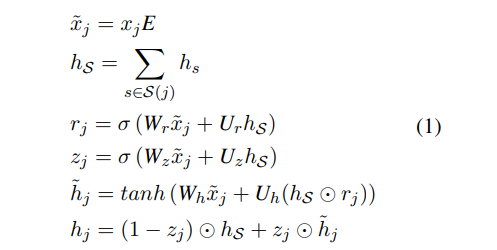

In [5]:
#reference: https://github.com/majingCUHK/Rumor_RvNN
class RecursiveUnit(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RecursiveUnit, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.E = nn.Linear(emb_size, hidden_size)
        self.W_z = nn.Linear(hidden_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)
        self.W_r = nn.Linear(hidden_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, cur_x, xs):
        x_j_ = self.E(cur_x)
        h_s = torch.zeros((1,self.hidden_size))
        for x in xs:
            if x.size()[1] == self.emb_size:
                x_ = self.E(x)
                r = torch.sigmoid(self.W_r(x_))
                z = torch.sigmoid(self.W_z(x_))
                h_ = torch.tanh(self.W_h(x_))
                hj = h_*z
            else:
                hj = x
            h_s += hj

        r_j = torch.sigmoid(self.W_r(x_j_) + self.U_r(h_s))
        
        z_j = torch.sigmoid(self.W_z(x_j_) + self.U_z(h_s))
        
        h_j_ = torch.tanh(self.W_h(x_j_) + self.U_h(h_s * r_j))
        
        h_j = (1 - z_j) * h_s + z_j * h_j_
        
        return h_j

class RecursiveModel(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RecursiveModel, self).__init__()
        self.unit = RecursiveUnit(emb_size, hidden_size)
        self.ffnn = nn.Sequential(nn.Linear(hidden_size,1),
                                  # nn.ReLU(),
                                  # nn.Dropout(0.3),
                                  # nn.Linear(64,1),
                                  nn.Sigmoid())

    def forward(self, bu_list, ret_dict):
        node_embs = dict()
        while bu_list:
            bu = bu_list.popleft()
            parent = bu[-1]
            a = ret_dict['tid_data'][int(ret_dict['node_tid'][parent])]
            # parent_stat = np.array(a.drop(columns=['in_reply_to_status_id','emb']))
            parent_emb = np.array(a.emb.iloc[0])
            parent_emb = parent_emb.reshape((1,parent_emb.shape[0]))
            # print(parent_stat)
            # parent_emb = torch.FloatTensor(np.hstack([parent_emb,parent_stat]))
            parent_emb = torch.FloatTensor(parent_emb)
            children = bu[:-1]
            child_embs = []
            for child in children:
                if child in node_embs:
                    child_emb = node_embs[child]
                else:
                    a = ret_dict['tid_data'][int(ret_dict['node_tid'][child])]
                    # child_stat = np.array(a.drop(columns=['in_reply_to_status_id','emb']))
                    child_emb = np.array(a.emb.iloc[0])
                    child_emb = child_emb.reshape((1,child_emb.shape[0]))
                    # child_emb = torch.FloatTensor(np.hstack([child_emb,child_stat]))
                    child_emb = torch.FloatTensor(child_emb)
                child_embs.append(child_emb)
                
            output = self.unit(parent_emb, child_embs)
            node_embs[parent] = output
            
        x = node_embs[0]
        logits = self.ffnn(x)
        return logits

### clear missing seqs

In [214]:
with open('train.data.txt') as file:
    train_seq = file.readlines()
with open('dev.data.txt') as file:
    dev_seq = file.readlines()

In [215]:
len(dev_seq)

632

In [205]:
with open('train.label.txt') as file:
    train_labels = file.readlines()
with open('dev.label.txt') as file:
    dev_labels = file.readlines()

In [196]:
a = []
labels = []
for i in range(len(train_seq)):
    if build_tree(train_seq[i], train) is not None:
        a.append(train_seq[i])
        labels.append(train_labels[i])

In [197]:
with open('./tree/train.data.pkl','wb') as file:
    pickle.dump(a,file)
with open('./tree/train.label.pkl', 'wb') as file:
    pickle.dump(labels,file)

In [206]:
a = []
labels = []
for i in range(len(dev_seq)):
    if build_tree(dev_seq[i], dev) is not None:
        a.append(dev_seq[i])
        labels.append(dev_labels[i])
    else:
        print('no')

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


In [207]:
with open('./tree/dev.data.pkl','wb') as file:
    pickle.dump(a,file)
with open('./tree/dev.label.pkl', 'wb') as file:
    pickle.dump(labels,file)

In [170]:
with open('test.data.txt') as file:
    test_seq = file.readlines()
a = []
for seq in tqdm(test_seq):
    if build_tree(seq, test) is not None:
        a.append(seq)
    else:
        print('no')

100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [00:09<00:00, 60.39it/s]


In [171]:
with open('./tree/test.data.pkl','wb') as file:
    pickle.dump(a,file)

### Ultils

In [6]:
class TreeDataset(Data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_f1_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, pos_label=1, average="binary")
    return f

def get_roc_auc_from_logits(logits, labels):
    preds = (logits >= 0.5).astype(int)
    return roc_auc_score(preds,labels)

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    all_log = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for data, labels in dataloader:
            index = 0
            logits = None
            for seq in data:
                # print(seq)
                ret_dict = build_tree(seq, dev)
                # print(ret_dict)
                bu_list = bottom_up_list(ret_dict)
                output = net(bu_list, ret_dict)
                if index == 0:
                    logits = output
                else:
                    logits = torch.cat((logits,output),dim=0)
                index += 1
            mean_loss += criterion(logits.squeeze(), labels.float()).item()
            # mean_acc += get_accuracy_from_logits(logits, labels)
            
            all_log = np.hstack((all_log, logits.squeeze()))
            all_labels = np.hstack((all_labels, labels))
            count += 1
        
        f = get_f1_from_logits(all_log, all_labels)
        try:
            roc_auc = get_roc_auc_from_logits(all_log, all_labels)
        except:
            roc_auc = 0
    return f, roc_auc, mean_loss / count

### Process data

In [219]:
with open('train.data.txt') as file:
    train_seq = file.readlines()
with open('dev.data.txt') as file:
    dev_seq = file.readlines()
    
train_id = pd.read_csv('./tree/train_tree.csv')
dev_id = pd.read_csv('./tree/dev_tree.csv')
test_id = pd.read_csv('./tree/test_tree.csv')

In [221]:
train_stat = pd.read_csv('./tree/train_scaled_stat_df.csv')
dev_stat = pd.read_csv('./tree/dev_scaled_stat_df.csv')
test_stat = pd.read_csv('./tree/test_scaled_stat_df.csv')

In [222]:
train_emb = pd.read_csv('train_emb.csv')
dev_emb = pd.read_csv('dev_emb.csv')

train_emb['0'] = train_emb['0'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
dev_emb['0'] = dev_emb['0'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])

In [223]:
test_emb = pd.read_csv('test_emb.csv')

test_emb['0'] = test_emb['0'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])

In [36]:
train_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20321 entries, 0 to 20320
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tweet_id                       20321 non-null  int64  
 1   text                           19364 non-null  object 
 2   created_at                     20321 non-null  object 
 3   user_id                        20321 non-null  int64  
 4   in_reply_to_status_id          18518 non-null  float64
 5   user_engagement                20321 non-null  float64
 6   contributors                   0 non-null      float64
 7   possibly_sensitive             5320 non-null   float64
 8   possibly_sensitive_appealable  5320 non-null   float64
 9   following_rate                 20321 non-null  float64
 10  retweet_count                  20321 non-null  int64  
 11  favorite_count                 20321 non-null  int64  
 12  mentioned_url_num              20321 non-null 

In [22]:
train_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20321 entries, 0 to 20320
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_engagement                20321 non-null  float64
 1   possibly_sensitive             20321 non-null  float64
 2   possibly_sensitive_appealable  20321 non-null  float64
 3   following_rate                 20321 non-null  float64
 4   retweet_count                  20321 non-null  float64
 5   favorite_count                 20321 non-null  float64
 6   mentioned_url_num              20321 non-null  float64
 7   id_num                         20321 non-null  float64
 8   favourite_rate                 20321 non-null  float64
 9   question_mark                  20321 non-null  float64
 10  followers_count                20321 non-null  float64
 11  friends_count                  20321 non-null  float64
 12  listed_count                   20321 non-null 

In [224]:
train_stat['tweet_id'] = train_id['tweet_id']
dev_stat['tweet_id'] = dev_id['tweet_id']
test_stat['tweet_id'] = test_id['tweet_id']
train_stat['in_reply_to_status_id'] = train_id['in_reply_to_status_id']
dev_stat['in_reply_to_status_id'] = dev_id['in_reply_to_status_id']
test_stat['in_reply_to_status_id'] = test_id['in_reply_to_status_id']

In [225]:
dev_zero = []
for column in dev_stat.columns:
    if (dev_stat[column] != 0).sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if (train_stat[column] != 0).sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)
test_stat.drop(columns=dev_zero, inplace=True)

['possibly_sensitive_appealable', 'following_rate', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['possibly_sensitive_appealable', 'following_rate', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


In [226]:
train_stat['emb'] = train_emb['0']
dev_stat['emb'] = dev_emb['0']
test_stat['emb'] = test_emb['0']

In [227]:
train_stat.to_csv('./tree/train.csv', index=False)
dev_stat.to_csv('./tree/dev.csv', index=False)
test_stat.to_csv('./tree/test.csv',index=False)

In [10]:
train = pd.read_csv('./tree/train.csv')
dev = pd.read_csv('./tree/dev.csv')
test = pd.read_csv('./tree/test.csv')

In [11]:
train['emb'] = train['emb'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
dev['emb'] = dev['emb'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
test['emb'] = test['emb'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])

In [230]:
dev.emb.iloc[0]

[-0.49342307448387146,
 0.007588261738419533,
 0.3134470582008362,
 -0.3277294337749481,
 -0.4458341896533966,
 0.09291649609804153,
 0.6744552254676819,
 0.3314012885093689,
 -0.025104980915784836,
 -0.42842692136764526,
 0.03950155898928642,
 -0.43437039852142334,
 0.043519288301467896,
 0.5027838945388794,
 -0.7783005237579346,
 -0.38126909732818604,
 0.03475367650389671,
 0.8293481469154358,
 0.23759141564369202,
 0.560247540473938,
 0.013833638280630112,
 -0.5514167547225952,
 0.16355271637439728,
 -0.7119957208633423,
 0.05473170056939125,
 -0.30965033173561096,
 0.13083899021148682,
 0.3167490065097809,
 0.14047087728977203,
 0.021343106403946877,
 0.12247911095619202,
 0.3301854133605957,
 -0.02477826178073883,
 -0.5211730003356934,
 0.041423384100198746,
 -0.11632643640041351,
 0.16170573234558105,
 0.28287050127983093,
 0.06229351460933685,
 0.25586023926734924,
 -0.35123559832572937,
 -0.3039960563182831,
 0.22001929581165314,
 -0.09470778703689575,
 -0.23549802601337433,
 -

### Prepare

In [7]:
with open('./tree/train.label.pkl','rb') as file:
    train_labels = pickle.load(file)
with open('./tree/dev.label.pkl','rb') as file:
    dev_labels = pickle.load(file)
    
y_train = []
y_dev = []

for label in train_labels:
    if label.strip() == 'rumour':
        y_train.append(1)
    else:
        y_train.append(0)

for label in dev_labels:
    if label.strip() == 'rumour':
        y_dev.append(1)
    else:
        y_dev.append(0)

In [8]:
y_train = np.array(y_train)
y_dev = np.array(y_dev)

In [9]:
torch.manual_seed(42)

with open('./tree/train.data.pkl','rb') as file:
    train_seq = pickle.load(file)
with open('./tree/dev.data.pkl','rb') as file:
    dev_seq = pickle.load(file)
    
w_nonr = len(y_train)/(len(y_train)-y_train.sum())
w_r = len(y_train)/(y_train.sum())
weights = []
for l in y_train:
    if l == 0:
        weights.append(w_nonr)
    else:
        weights.append(w_r)
weights = torch.FloatTensor(weights)

train_set = TreeDataset(train_seq, y_train)
dev_set = TreeDataset(dev_seq, y_dev)

train_sampler = Data.WeightedRandomSampler(weights, len(train_set), replacement=True)
train_loader = Data.DataLoader(train_set, sampler=train_sampler, batch_size=128)
dev_loader = Data.DataLoader(dev_set, batch_size=128, shuffle=False)

### train

In [12]:
device = torch.device('cuda')
net = RecursiveModel(768,128)
# net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 0.001)

In [14]:
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

for ep in range(40):
    eps.append(ep)
    net.train()
    for it, (data, labels) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        index = 0
        logits = None
        for seq in data:
            ret_dict = build_tree(seq, train)
            bu_list = bottom_up_list(ret_dict)
            output = net(bu_list, ret_dict)
            if index == 0:
                logits = output
            else:
                logits = torch.cat((logits,output),dim=0)
            index += 1
        loss = criterion(logits.squeeze(), labels.float().clone().detach())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, roc_auc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development ROCAUC: {}; Development Loss: {}".format(dev_acc, roc_auc, dev_loss))
    torch.save(net.state_dict(), 'D:\\RvNN_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.2252281904220581; Accuracy: 0.9296875; Time taken (s): 4.673837661743164
Iteration 10 of epoch 0 complete. 
 Loss: 0.24691587686538696; Accuracy: 0.890625; Time taken (s): 45.9657883644104
Development F1: 0.6181818181818183; Development ROCAUC: 0.7207163663547548; Development Loss: 0.5097601771354675
Iteration 0 of epoch 1 complete. 
 Loss: 0.297404944896698; Accuracy: 0.859375; Time taken (s): 32.977211236953735
Iteration 10 of epoch 1 complete. 
 Loss: 0.26544106006622314; Accuracy: 0.8828125; Time taken (s): 47.15720844268799
Development F1: 0.6321839080459771; Development ROCAUC: 0.7255072571090048; Development Loss: 0.5057483434677124
Iteration 0 of epoch 2 complete. 
 Loss: 0.20224225521087646; Accuracy: 0.8828125; Time taken (s): 29.834994077682495
Iteration 10 of epoch 2 complete. 
 Loss: 0.1906273066997528; Accuracy: 0.9296875; Time taken (s): 43.39777398109436
Development F1: 0.6425992779783393; Development ROCAUC: 0.7651098901098901

In [106]:
a = build_tree(train_seq[0],train)

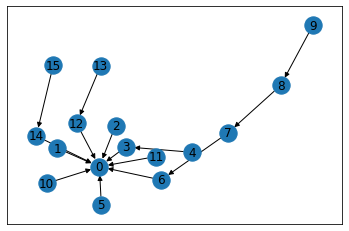

In [107]:
draw_tree(a['nodes'],a['edges'])